In [1]:
import keras
from keras.models import load_model, model_from_json

Using TensorFlow backend.
/users/avanti/anaconda3/envs/py376/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/avanti/anaconda3/envs/py376/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/avanti/anaconda3/envs/py376/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/avanti/anacon

In [2]:
import tensorflow as tf

def multinomial_nll(true_counts, logits):
    """Compute the multinomial negative log-likelihood
    Args:
      true_counts: observed count values
      logits: predicted logit values
    """
    counts_per_example = tf.reduce_sum(true_counts, axis=-1)
    dist = tf.contrib.distributions.Multinomial(total_count=counts_per_example,
                                                logits=logits)
    return -tf.reduce_sum(dist.log_prob(true_counts)) / tf.to_float(tf.shape(true_counts)[0])


class MultichannelMultinomialNLL(object):
    def __init__(self, n):
        self.__name__ = "MultichannelMultinomialNLL"
        self.n = n

    def __call__(self, true_counts, logits):
        for i in range(self.n):
            loss = multinomial_nll(true_counts[..., i], logits[..., i])
            if i == 0:
                total = loss
            else:
                total += loss
        return total

    def get_config(self):
        return {"n": self.n}

from keras.utils import CustomObjectScope
from keras.models import load_model
with CustomObjectScope({'MultichannelMultinomialNLL': MultichannelMultinomialNLL}):
    keras_model = load_model("model.h5")







The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use `tf.cast` instead.


In [3]:
keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq (InputLayer)                (None, 1000, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1000, 64)     6464        seq[0][0]                        
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1000, 64)     12352       conv1d_1[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, 1000, 64)     0           conv1d_1[0][0]                   
                                                                 conv1d_2[0][0]                   
__________

In [4]:
def get_out_tensor(inp_tensor, layer_to_copy, param_overrides={}):
    new_config = dict(layer_to_copy.get_config().items())
    for param_name in param_overrides:
        assert param_name in new_config
        new_config[param_name] = param_overrides[param_name]
    new_layer = layer_to_copy.__class__.from_config(new_config)
    adjusted_input_shape = list(layer_to_copy.input_shape)
    assert len(adjusted_input_shape)==3
    adjusted_input_shape[1] = None #flexible input len for convs
    adjusted_input_shape = tuple(adjusted_input_shape)
    new_layer.build(adjusted_input_shape)
    new_layer.set_weights(layer_to_copy.get_weights())
    out_tensor = new_layer(inp_tensor)
    return out_tensor

In [5]:
inp_tensor = keras.layers.Input((None,4))
conv1_out = get_out_tensor(inp_tensor=inp_tensor,
                           layer_to_copy=keras_model.layers[1],
                           param_overrides={'padding': 'same'})
conv2_out = get_out_tensor(inp_tensor=conv1_out,
                           layer_to_copy=keras_model.layers[2],
                           param_overrides={'padding': 'same'})
add1_out = keras.layers.Add()([conv1_out, conv2_out])
conv3_out =  get_out_tensor(inp_tensor=add1_out,
                            layer_to_copy=keras_model.layers[4],
                            param_overrides={'padding': 'same'})
add2_out = keras.layers.Add()([add1_out, conv3_out])
conv4_out =  get_out_tensor(inp_tensor=add2_out,
                            layer_to_copy=keras_model.layers[6],
                            param_overrides={'padding': 'same'})

conv1_gap = keras.layers.GlobalAveragePooling1D()(conv1_out)
conv2_gap = keras.layers.GlobalAveragePooling1D()(conv2_out)
conv3_gap = keras.layers.GlobalAveragePooling1D()(conv3_out)
conv4_gap = keras.layers.GlobalAveragePooling1D()(conv4_out)

concat = keras.layers.Concatenate(axis=-1)([conv1_gap, conv2_gap, conv3_gap, conv4_gap])
embedding_model = keras.models.Model(inputs=inp_tensor, outputs=concat)

In [6]:
embedding_model.save("embedding_model.h5")

In [7]:
import numpy as np
embedding_model.predict(np.random.random((10, 41, 4))).shape

(10, 256)

In [8]:
embedding_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 4)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 64)     6464        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, None, 64)     12352       conv1d_1[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, None, 64)     0           conv1d_1[0][0]                   
                                                                 conv1d_2[0][0]                   
__________

In [9]:
import numpy as np
import h5py

f = h5py.File("/oak/stanford/groups/akundaje/avsec/basepair/data/"
              +"processed/comparison/output/nexus,peaks,OSNK,0,10"
              +",1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE"
              +",FALSE,1/deeplift.imp_score.h5", "r")
#f = h5py.File("/users/avanti/deeplift.imp_score.h5","r")
nanog_mask = np.array(f['metadata']['interval_from_task'][:]=='Nanog')
nanog_profile_wn_hypimp = np.array(f["hyp_imp/Nanog/profile/wn"][:])[nanog_mask]
onehot_seq = np.array(f["inputs/seq"][:])[nanog_mask]
nanog_profile_wn_contribs = nanog_profile_wn_hypimp*onehot_seq

In [10]:
nanog_profile_wn_contribs.shape

(55233, 1000, 4)

/mnt/lab_data2/avanti/tfmodisco
commit 20e04f852f6d325f58b2fec20795a38070b879ab (HEAD -> filterembed, origin/filterembed)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Thu May 7 15:38:54 2020 -0700

    slightly nicer nb with scores summed across tasks
/mnt/lab_data2/avanti/tfmodisco_bio_experiments/bpnet/trial1


TF-MoDISco is using the TensorFlow backend.
/users/avanti/anaconda3/envs/py376/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


MEMORY 3.187986432
On task Nanog_profile_wn
Computing windowed sums on original
Generating null dist
peak(mu)= 0.00754788601747714
Computing threshold
Thresholds from null dist were -0.026598811149597168  and  0.2509317398071289
Passing windows frac was 0.04676685078463518 , which is above  0.03 ; adjusting
Final raw thresholds are -0.3184376752376554  and  0.3184376752376554
Final transformed thresholds are -0.9699999852203116  and  0.9699999852203116


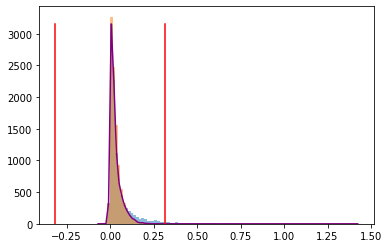

Got 98300 coords
After resolving overlaps, got 98300 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9698999852203116
MEMORY 5.104472064
98300 identified in total
1 activity patterns with support >= 2000 out of 3 possible patterns
Metacluster sizes:  [98297]
Idx to activities:  {0: '1'}
MEMORY 5.105598464
On metacluster 0
Metacluster size 98297 limited to 50000
Relevant tasks:  ('Nanog_profile_wn',)
Relevant signs:  (1,)


/users/avanti/anaconda3/envs/py376/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 50000
(Round 1) Computing coarse affmat
MEMORY 5.108092928
Beginning embedding computation
Finished embedding computation in 18.2 s
Starting affinity matrix computations
Normalization computed in 0.23 s
Cosine similarity mat computed in 15.58 s
Normalization computed in 0.18 s
Cosine similarity mat computed in 15.36 s
Finished affinity matrix computations in 49.41 s
(Round 1) Compute nearest neighbors from coarse affmat
MEMORY 15.137726464
Computed nearest neighbors in 192.4 s
MEMORY 15.955976192
(Round 1) Computing affinity matrix on nearest neighbors
MEMORY 15.955976192
Launching nearest neighbors affmat calculation job
MEMORY 16.191971328
Parallel runs completed
MEMORY 16.648208384
Job completed in: 329.56 s
MEMORY 36.179341312
Launching nearest neighbors affmat calculation job
MEMORY 36.17325056
Parallel runs completed
MEMORY 36.288233472
Job completed in: 328.38 s
MEMORY 55.819333632
(Round 1) Computed affinity ma

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.7865932009345032


  4%|▍         | 2/50 [00:31<12:54, 16.13s/it]

Quality: 0.7876893765699391


100%|██████████| 50/50 [11:34<00:00, 13.88s/it]

Got 37 clusters after round 1
Counts:
{4: 1754, 8: 891, 28: 21, 18: 92, 2: 1910, 1: 2436, 9: 633, 5: 1524, 10: 518, 15: 226, 0: 2483, 17: 93, 35: 7, 6: 1190, 7: 1069, 3: 1899, 11: 505, 30: 16, 23: 51, 31: 15, 16: 185, 14: 267, 12: 417, 34: 9, 33: 14, 13: 318, 20: 83, 19: 91, 22: 56, 21: 59, 29: 17, 24: 47, 32: 14, 27: 27, 26: 43, 25: 45, 36: 3}
MEMORY 6.487576576
(Round 1) Aggregating seqlets in each cluster
MEMORY 6.487576576
Aggregating for cluster 0 with 2483 seqlets
MEMORY 6.487576576


Trimmed 49 out of 2483
Removed 1 duplicate seqlets
Aggregating for cluster 1 with 2436 seqlets
MEMORY 6.501081088
Trimmed 107 out of 2436
Skipped 1 seqlets
Aggregating for cluster 2 with 1910 seqlets
MEMORY 6.508367872
Trimmed 113 out of 1910
Skipped 1 seqlets
Aggregating for cluster 3 with 1899 seqlets
MEMORY 6.509862912
Trimmed 115 out of 1899
Aggregating for cluster 4 with 1754 seqlets
MEMORY 6.514905088
Trimmed 44 out of 1754
Aggregating for cluster 5 with 1524 seqlets
MEMORY 6.518546432
Trimmed 129 out of 1524
Aggregating for cluster 6 with 1190 seqlets
MEMORY 6.521143296
Trimmed 144 out of 1190
Aggregating for cluster 7 with 1069 seqlets
MEMORY 6.52199936
Trimmed 50 out of 1069
Aggregating for cluster 8 with 891 seqlets
MEMORY 6.524338176
Trimmed 57 out of 891
Aggregating for cluster 9 with 633 seqlets
MEMORY 6.524813312
Trimmed 92 out of 633
Aggregating for cluster 10 with 518 seqlets
MEMORY 6.525661184
Trimmed 122 out of 518
Skipped 1 seqlets
Aggregating for cluster 11 with 505

  0%|          | 0/50 [00:00<?, ?it/s]

Quality: 0.7734567584262686


  2%|▏         | 1/50 [00:08<06:32,  8.02s/it]

Quality: 0.7736917909698625


  4%|▍         | 2/50 [00:26<09:01, 11.28s/it]

Quality: 0.7738269345286632


 14%|█▍        | 7/50 [01:21<07:45, 10.81s/it]

Quality: 0.7738343928201254


100%|██████████| 50/50 [10:00<00:00, 12.02s/it]

Got 37 clusters after round 2
Counts:
{5: 1596, 1: 1934, 2: 1916, 4: 1678, 11: 238, 18: 108, 0: 2365, 6: 1391, 3: 1735, 7: 1117, 8: 799, 16: 124, 28: 32, 12: 227, 15: 137, 19: 93, 20: 74, 14: 188, 24: 45, 13: 209, 23: 47, 27: 38, 9: 469, 21: 55, 10: 332, 22: 49, 26: 42, 31: 18, 25: 43, 29: 25, 17: 122, 30: 20, 34: 9, 33: 12, 32: 14, 35: 9, 36: 7}
MEMORY 5.987344384
(Round 2) Aggregating seqlets in each cluster
MEMORY 5.987344384
Aggregating for cluster 0 with 2365 seqlets
MEMORY 5.987344384


Trimmed 116 out of 2365
Removed 16 duplicate seqlets
Aggregating for cluster 1 with 1934 seqlets
MEMORY 6.000746496
Trimmed 77 out of 1934
Skipped 1 seqlets
Removed 1 duplicate seqlets
Aggregating for cluster 2 with 1916 seqlets
MEMORY 6.001831936
Trimmed 41 out of 1916
Removed 9 duplicate seqlets
Aggregating for cluster 3 with 1735 seqlets
MEMORY 6.00797184
Trimmed 71 out of 1735
Aggregating for cluster 4 with 1678 seqlets
MEMORY 6.00989696
Trimmed 283 out of 1678
Aggregating for cluster 5 with 1596 seqlets
MEMORY 5.939810304
Trimmed 86 out of 1596
Aggregating for cluster 6 with 1391 seqlets
MEMORY 5.943844864
Trimmed 118 out of 1391
Removed 1 duplicate seqlets
Aggregating for cluster 7 with 1117 seqlets
MEMORY 5.946507264
Trimmed 122 out of 1117
Removed 4 duplicate seqlets
Aggregating for cluster 8 with 799 seqlets
MEMORY 5.947891712
Trimmed 66 out of 799
Aggregating for cluster 9 with 469 seqlets
MEMORY 5.948153856
Trimmed 40 out of 469
Removed 154 duplicate seqlets
Aggregating for 

Louvain completed 21 runs in 3.414511203765869 seconds
Similarity is 0.92258847; is_dissimilar is False
Inspecting for spurious merging
Wrote graph to binary file in 0.05768942832946777 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.0165619
Louvain completed 21 runs in 3.5313804149627686 seconds
Similarity is 0.5950737; is_dissimilar is True
Inspecting for spurious merging
Wrote graph to binary file in 0.03186941146850586 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.00416502
Louvain completed 21 runs in 3.546252727508545 seconds
Similarity is 0.8892996; is_dissimilar is False
Inspecting for spurious merging
Wrote graph to binary file in 0.00697636604309082 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.0107839
After 3 runs, maximum modularity is Q = 0.0240471
Louvain completed 23 runs in 3.9172680377960205 seconds
Similarity is 0.7104529; is_dissimilar is T

In [11]:
#print modisco commit hash
%cd /users/avanti/tfmodisco
!git log -n 1
%cd /users/avanti/tfmodisco_bio_experiments/bpnet/trial1

from importlib import reload

%matplotlib inline
import h5py
import numpy as np
import modisco
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.phenograph
reload(modisco.cluster.phenograph)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.cluster
reload(modisco.cluster)
import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.affinitymat.transformers
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)
import modisco.clusterinit.memeinit
reload(modisco.clusterinit.memeinit)

%matplotlib inline

workflow = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
    sliding_window_size=21,
    flank_size=10,
    target_seqlet_fdr=0.01,
    min_passing_windows_frac=0.03,
    max_passing_windows_frac=0.03,
    min_metacluster_size=2000,
    min_metacluster_size_frac=0.02,
    max_seqlets_per_metacluster=50000,
    seqlets_to_patterns_factory=
      modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
        #initclusterer_factory=modisco.clusterinit.memeinit.MemeInitClustererFactory(    
        #                meme_command="/software/meme/5.0.1/bin/meme",
        #                base_outdir="meme_out",            
        #                max_num_seqlets_to_use=10000,
        #                nmotifs=20, n_jobs=4),
        use_louvain=False,
        affmat_correlation_threshold=0.1,
        trim_to_window_size=30,
        initial_flank_to_add=10,
        embedder_factory=(modisco.seqlet_embedding
                          .onehot_model_output.KerasModelOutputEmbedder
                          .get_factory(model_h5="embedding_model.h5")),
        n_cores=10,
        final_min_cluster_size=30
    )
)

results = workflow(
    task_names=["Nanog_profile_wn"],
    contrib_scores={'Nanog_profile_wn': nanog_profile_wn_contribs},
    hypothetical_contribs={'Nanog_profile_wn': nanog_profile_wn_hypimp},
    one_hot=onehot_seq)

In [12]:
import h5py
import modisco.util
reload(modisco.util)
import os

file_path = "commit20e04f_corrthresh0p1_nomemeinit_4layerembedding_results.hdf5"
if (os.path.exists(file_path)):
    os.remove(file_path)
grp = h5py.File(file_path, "w")
results.save_hdf5(grp)
grp.close()

metacluster_0
activity pattern: [1]
metacluster_0 pattern_0
total seqlets: 5223
Task 0 hypothetical scores:


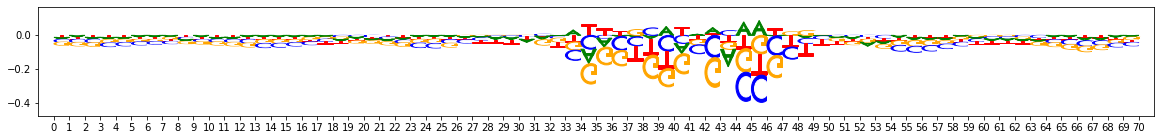

Task 0 actual importance scores:


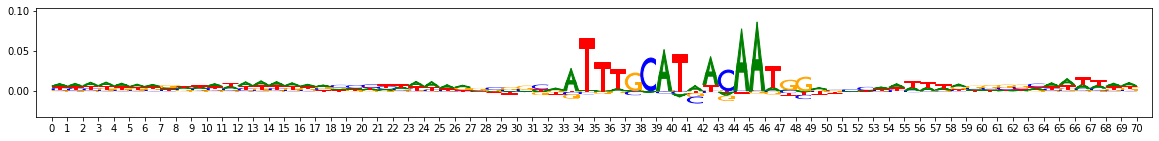

onehot, fwd and rev:


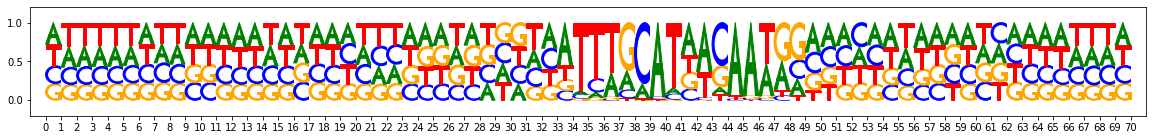

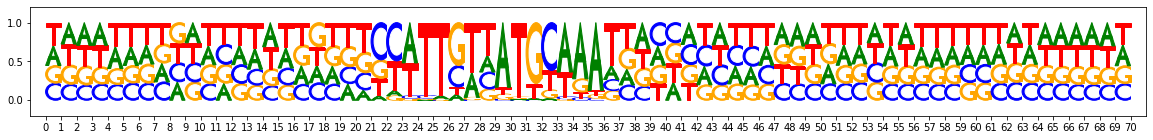

metacluster_0 pattern_1
total seqlets: 3594
Task 0 hypothetical scores:


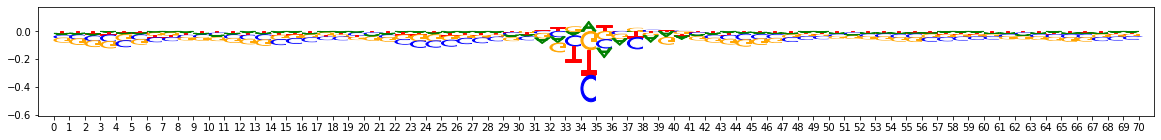

Task 0 actual importance scores:


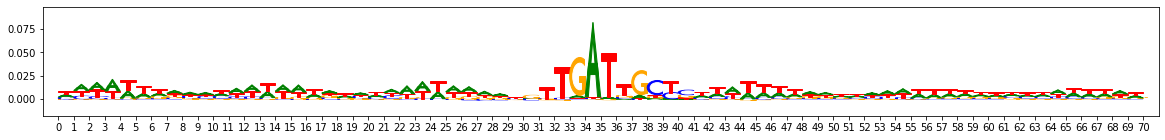

onehot, fwd and rev:


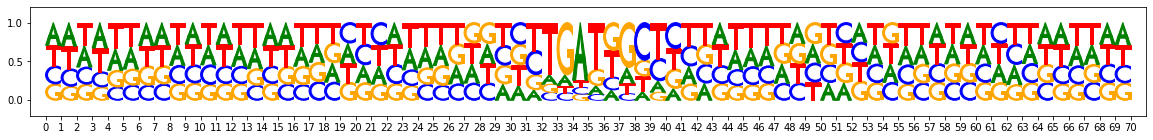

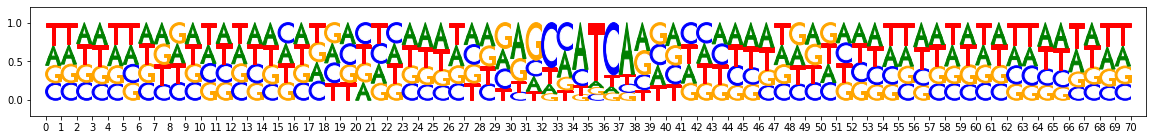

metacluster_0 pattern_2
total seqlets: 1699
Task 0 hypothetical scores:


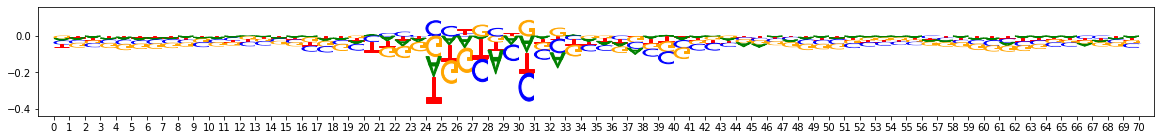

Task 0 actual importance scores:


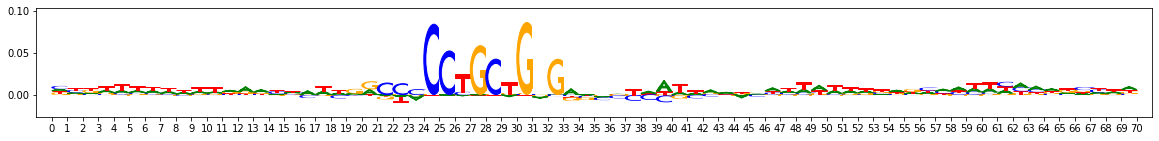

onehot, fwd and rev:


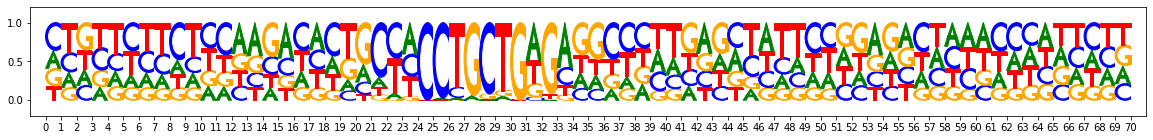

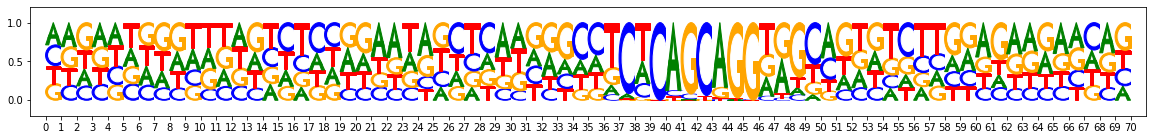

metacluster_0 pattern_3
total seqlets: 1282
Task 0 hypothetical scores:


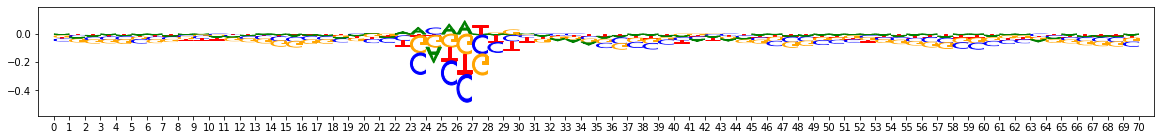

Task 0 actual importance scores:


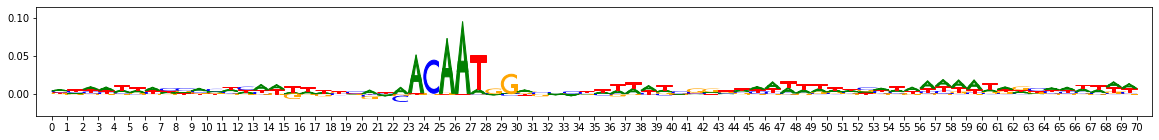

onehot, fwd and rev:


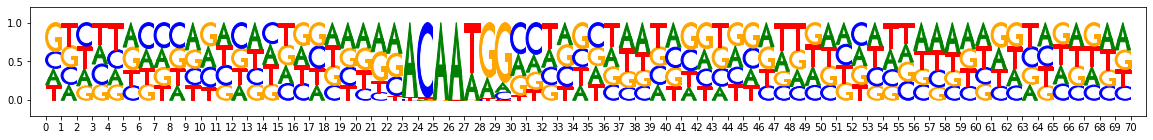

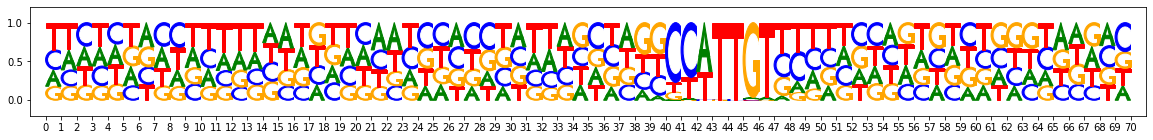

metacluster_0 pattern_4
total seqlets: 1012
Task 0 hypothetical scores:


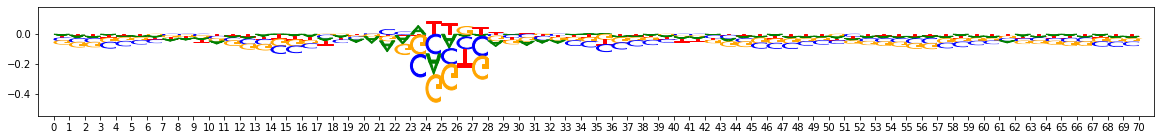

Task 0 actual importance scores:


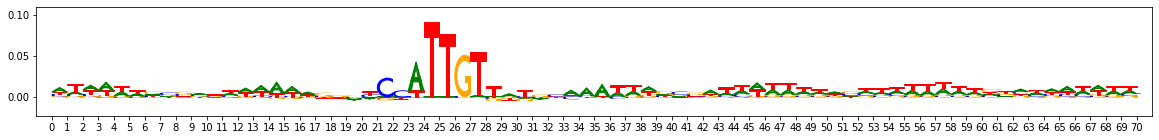

onehot, fwd and rev:


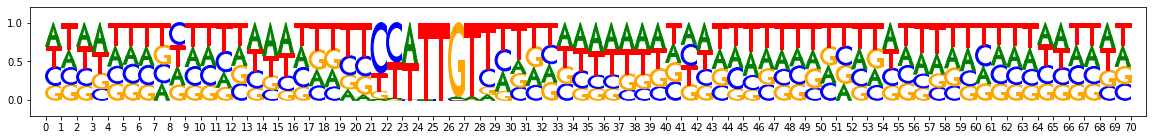

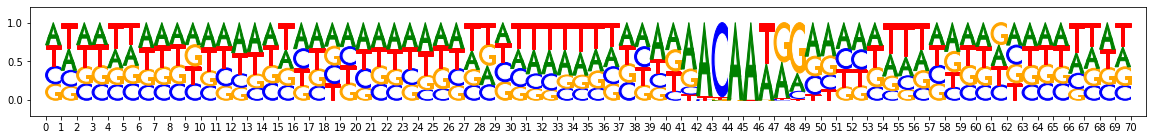

metacluster_0 pattern_5
total seqlets: 735
Task 0 hypothetical scores:


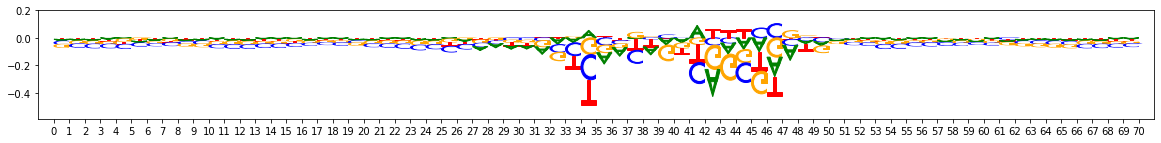

Task 0 actual importance scores:


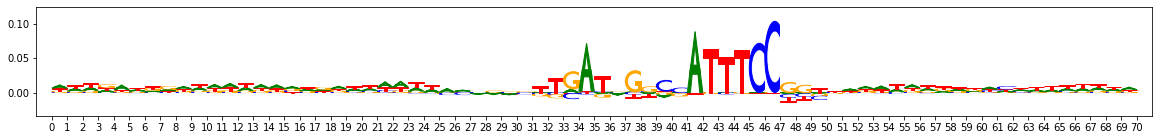

onehot, fwd and rev:


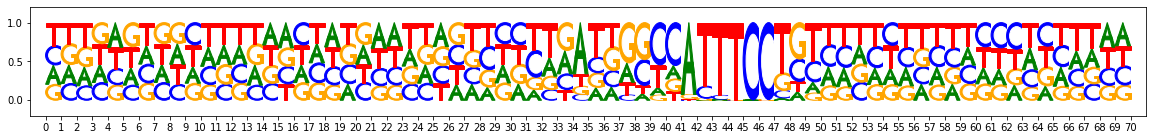

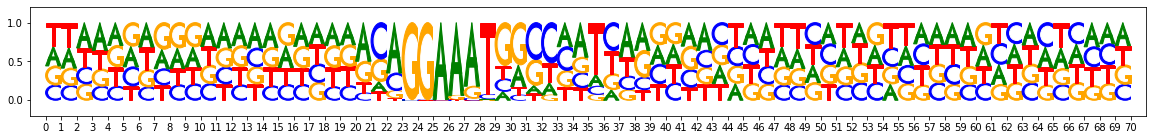

metacluster_0 pattern_6
total seqlets: 532
Task 0 hypothetical scores:


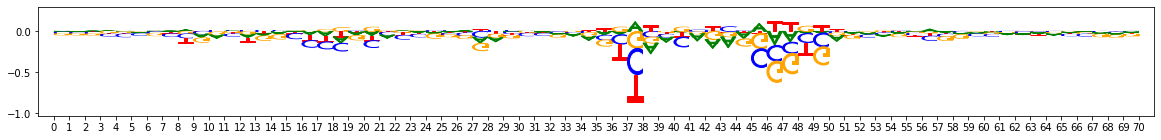

Task 0 actual importance scores:


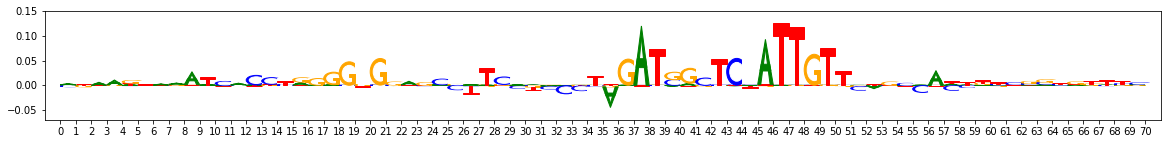

onehot, fwd and rev:


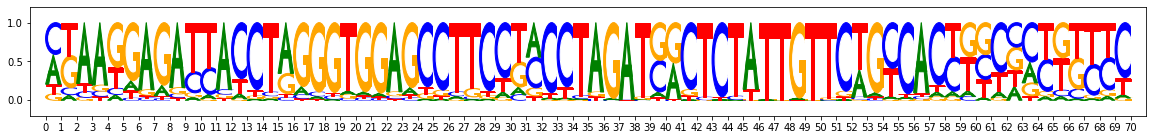

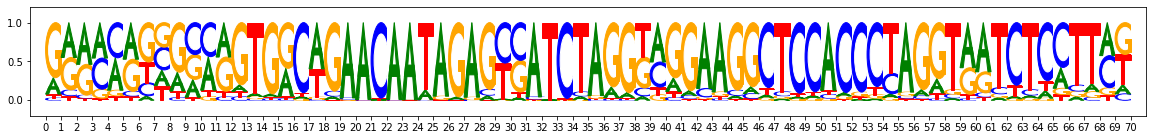

metacluster_0 pattern_7
total seqlets: 194
Task 0 hypothetical scores:


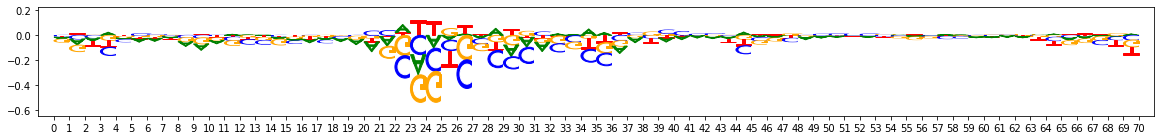

Task 0 actual importance scores:


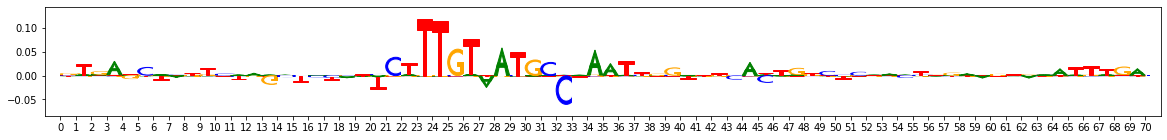

onehot, fwd and rev:


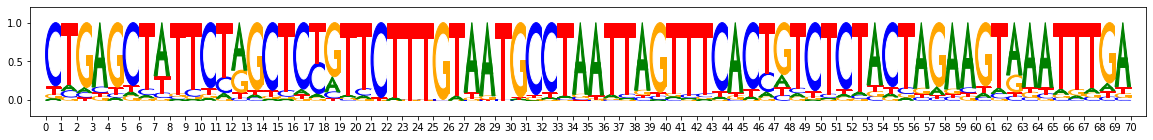

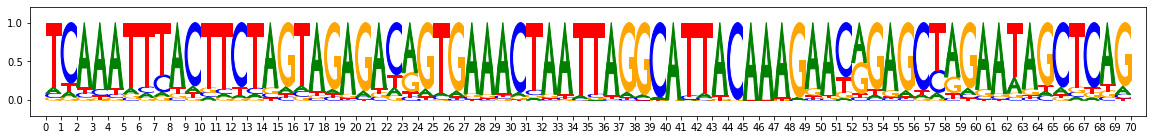

metacluster_0 pattern_8
total seqlets: 190
Task 0 hypothetical scores:


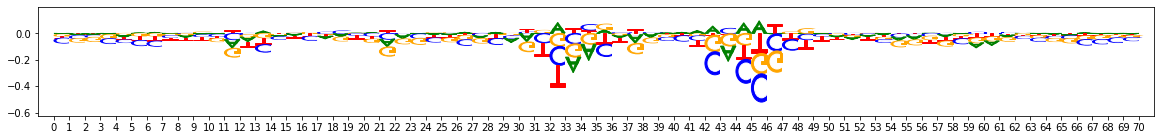

Task 0 actual importance scores:


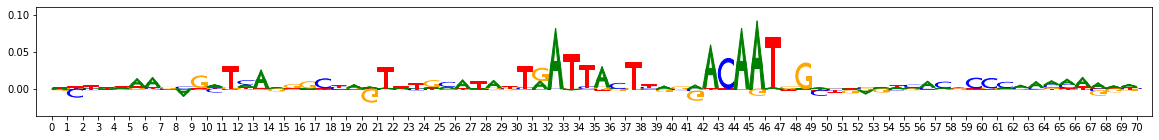

onehot, fwd and rev:


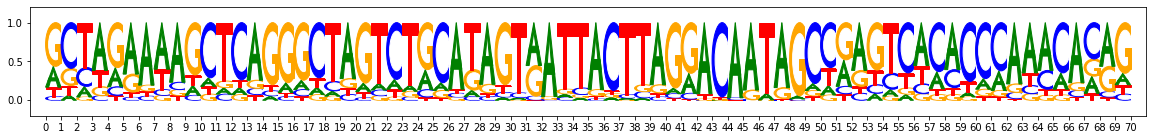

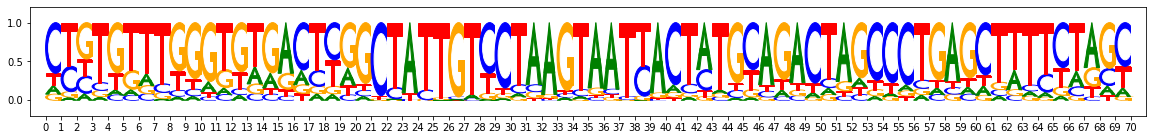

metacluster_0 pattern_9
total seqlets: 153
Task 0 hypothetical scores:


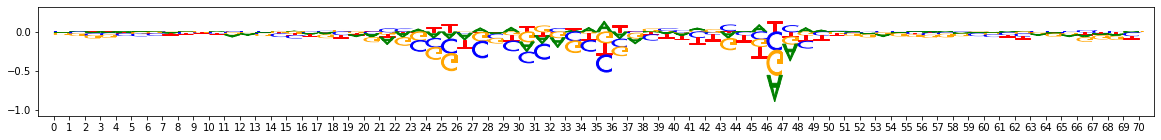

Task 0 actual importance scores:


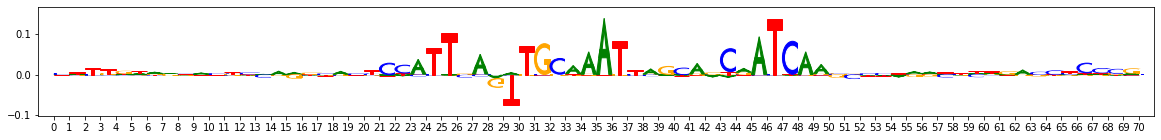

onehot, fwd and rev:


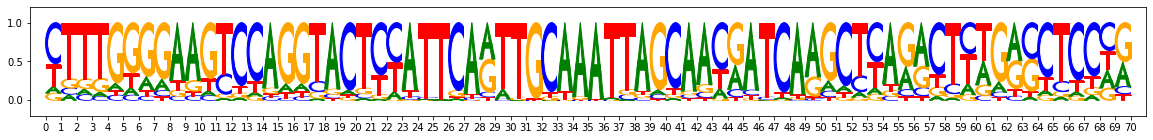

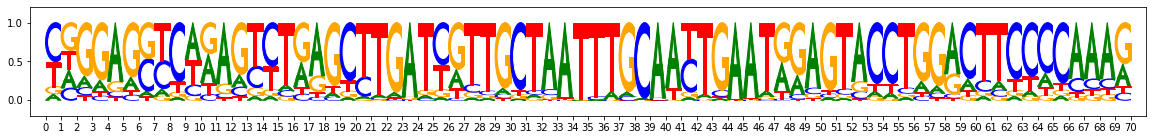

metacluster_0 pattern_10
total seqlets: 170
Task 0 hypothetical scores:


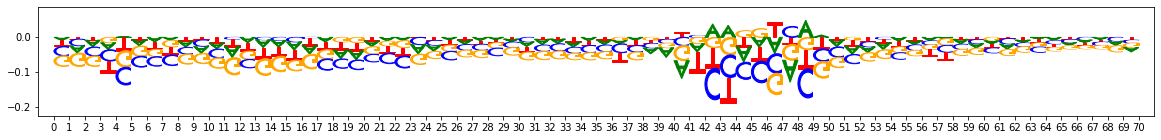

Task 0 actual importance scores:


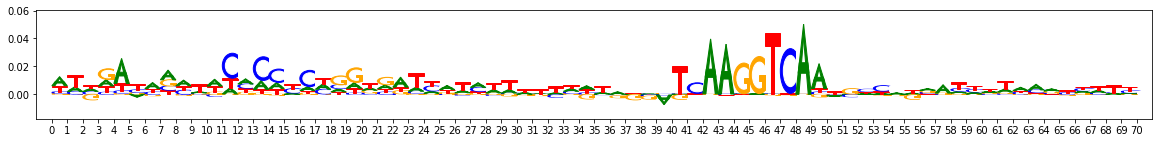

onehot, fwd and rev:


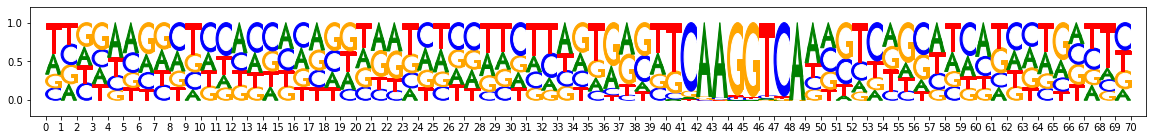

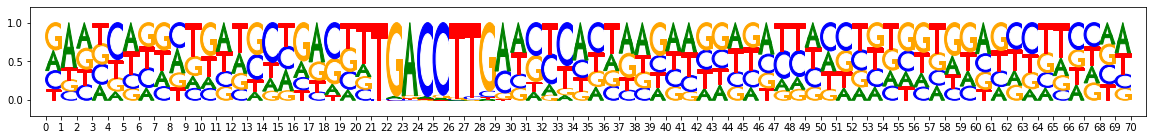

metacluster_0 pattern_11
total seqlets: 104
Task 0 hypothetical scores:


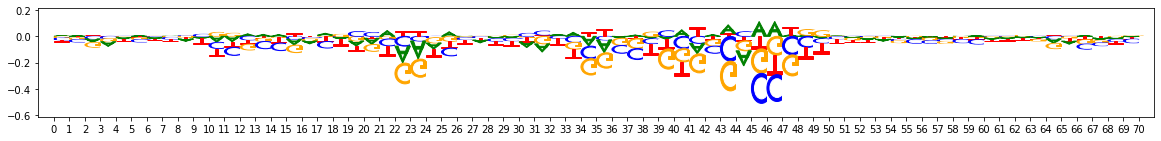

Task 0 actual importance scores:


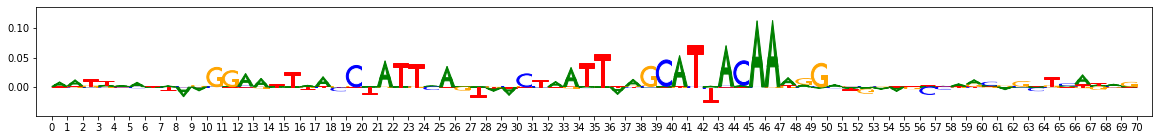

onehot, fwd and rev:


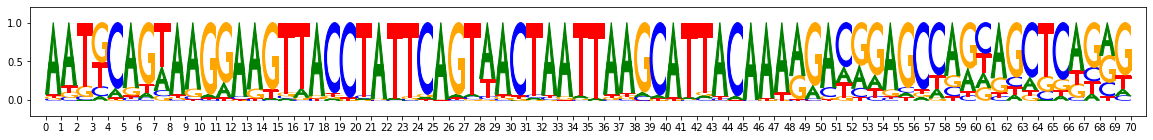

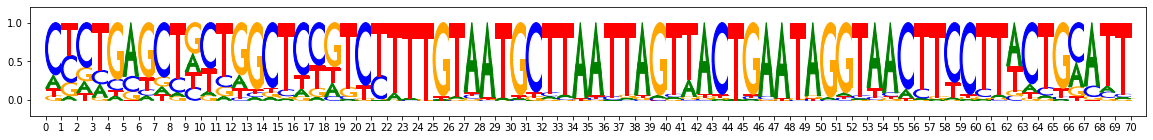

metacluster_0 pattern_12
total seqlets: 107
Task 0 hypothetical scores:


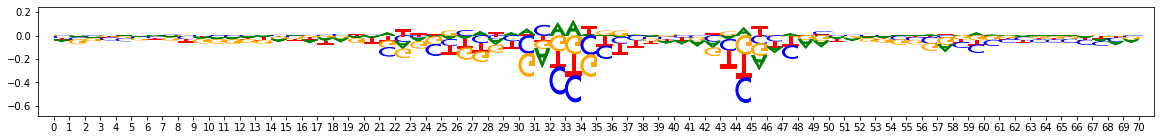

Task 0 actual importance scores:


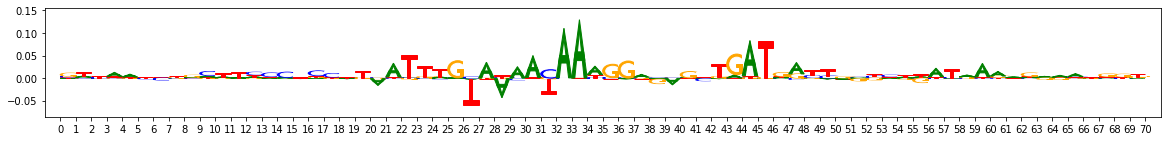

onehot, fwd and rev:


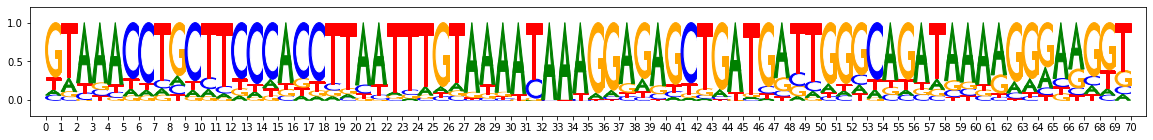

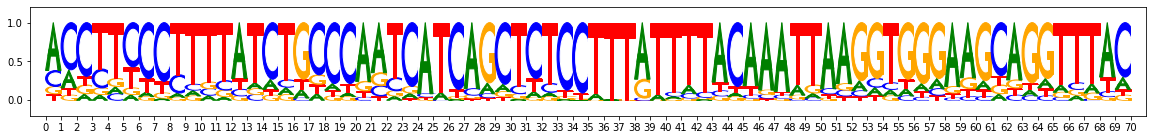

metacluster_0 pattern_13
total seqlets: 105
Task 0 hypothetical scores:


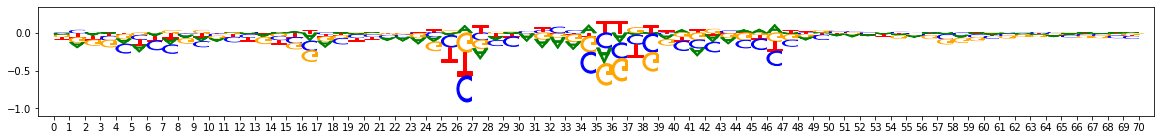

Task 0 actual importance scores:


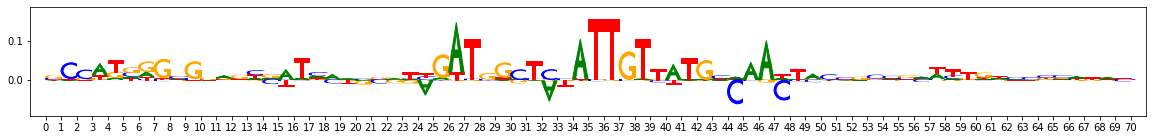

onehot, fwd and rev:


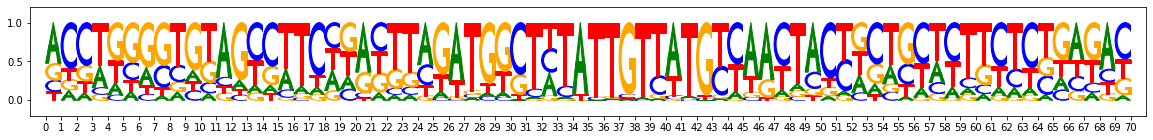

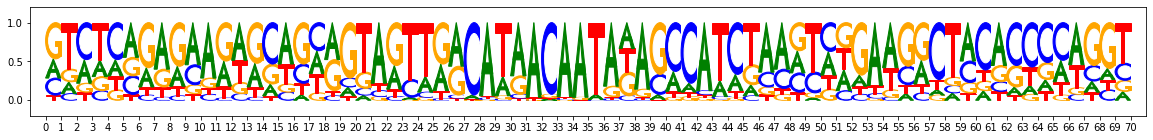

metacluster_0 pattern_14
total seqlets: 79
Task 0 hypothetical scores:


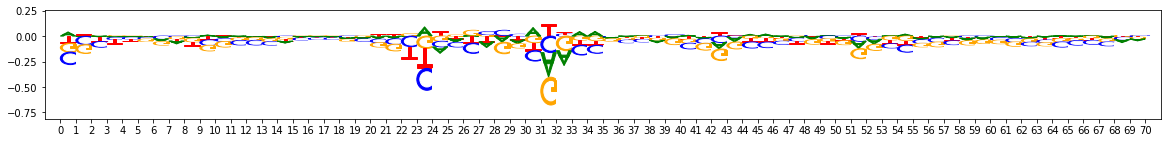

Task 0 actual importance scores:


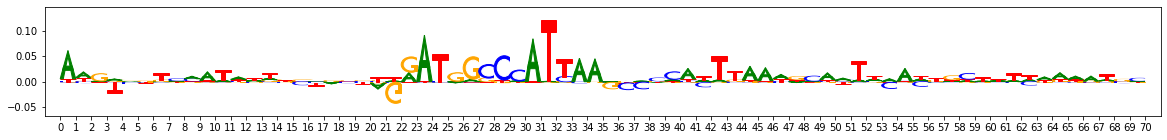

onehot, fwd and rev:


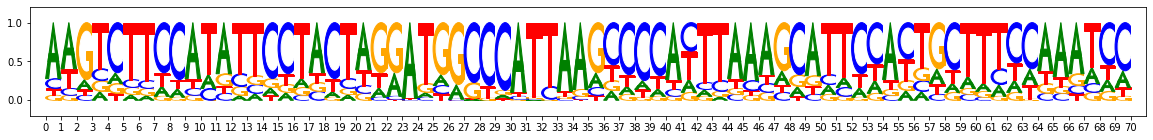

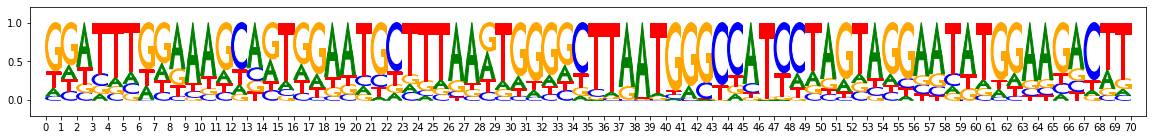

metacluster_0 pattern_15
total seqlets: 41
Task 0 hypothetical scores:


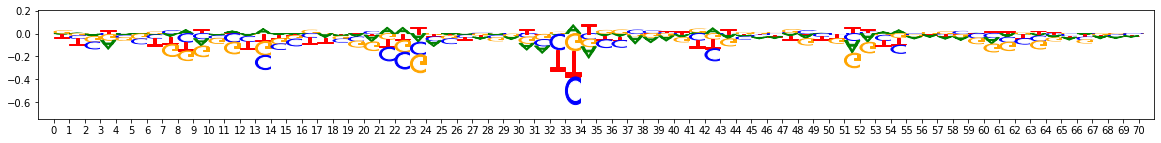

Task 0 actual importance scores:


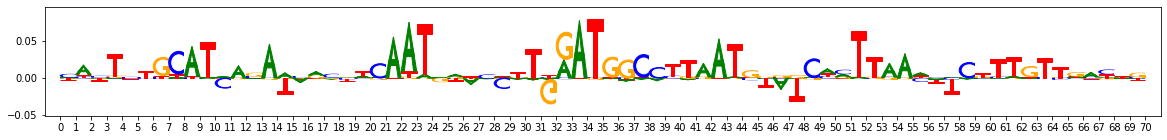

onehot, fwd and rev:


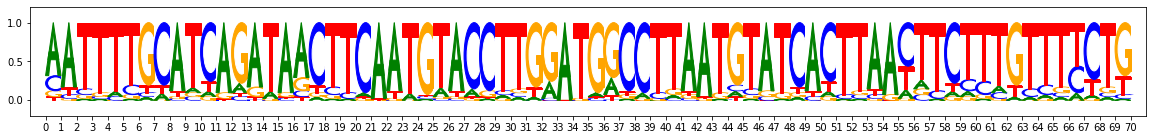

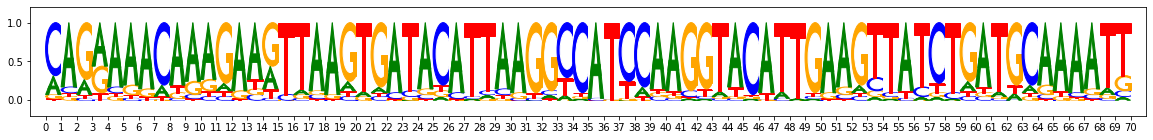

metacluster_0 pattern_16
total seqlets: 52
Task 0 hypothetical scores:


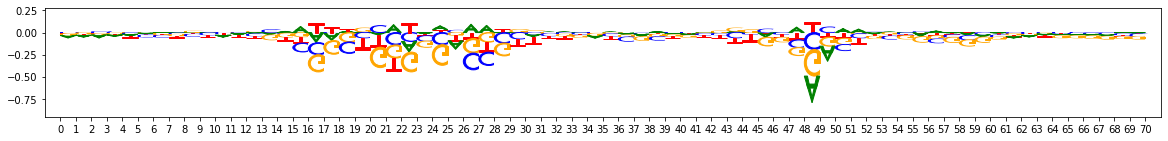

Task 0 actual importance scores:


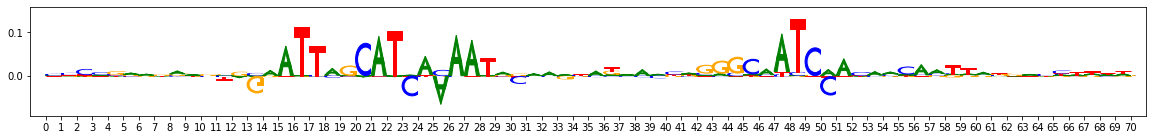

onehot, fwd and rev:


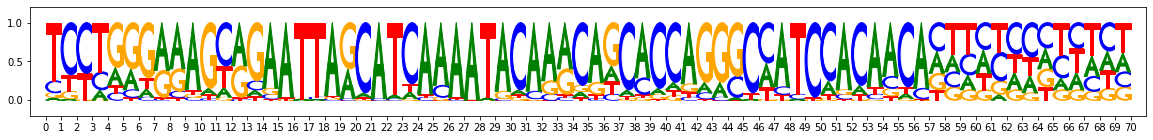

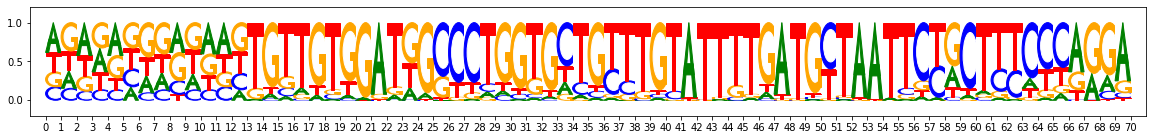

metacluster_0 pattern_17
total seqlets: 39
Task 0 hypothetical scores:


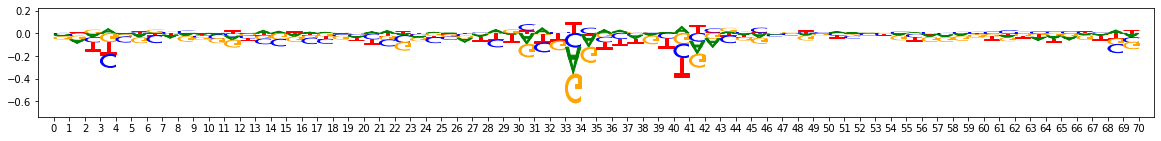

Task 0 actual importance scores:


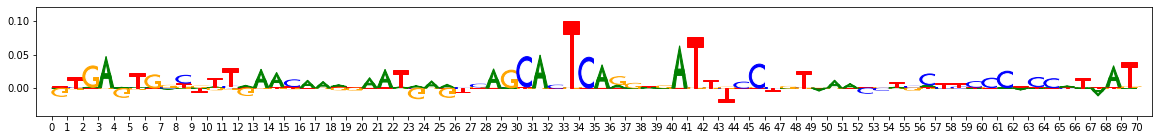

onehot, fwd and rev:


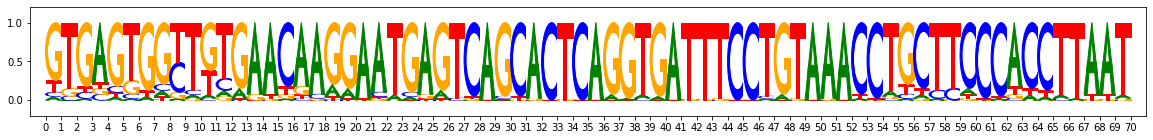

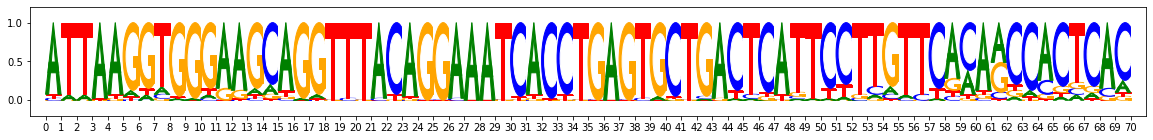

metacluster_0 pattern_18
total seqlets: 40
Task 0 hypothetical scores:


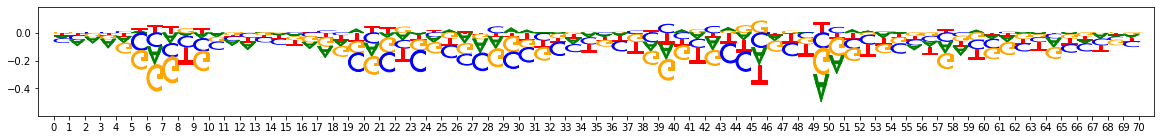

Task 0 actual importance scores:


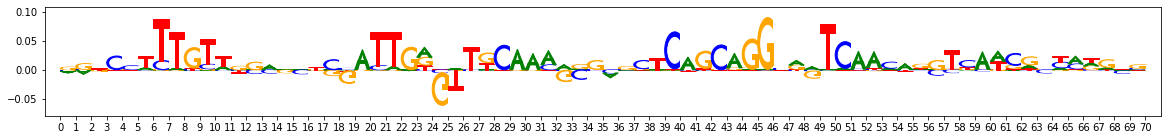

onehot, fwd and rev:


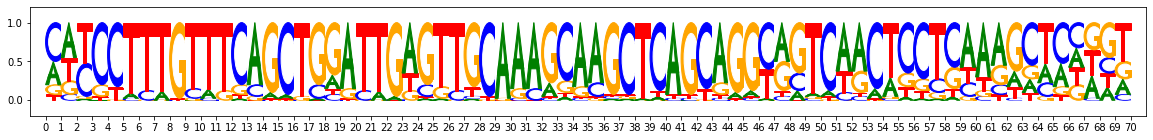

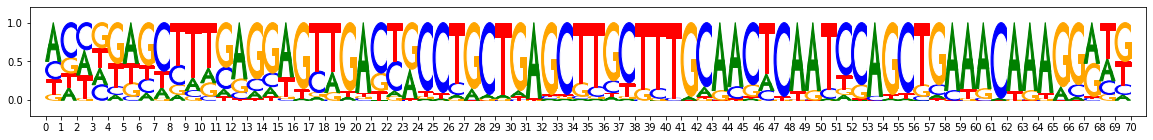

metacluster_0 pattern_19
total seqlets: 35
Task 0 hypothetical scores:


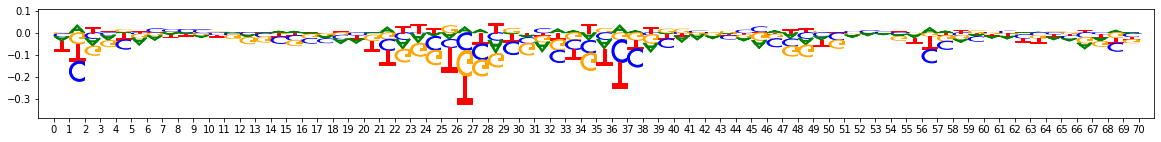

Task 0 actual importance scores:


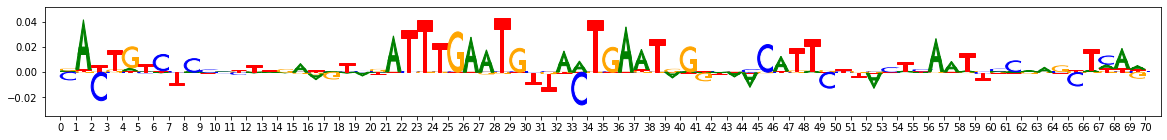

onehot, fwd and rev:


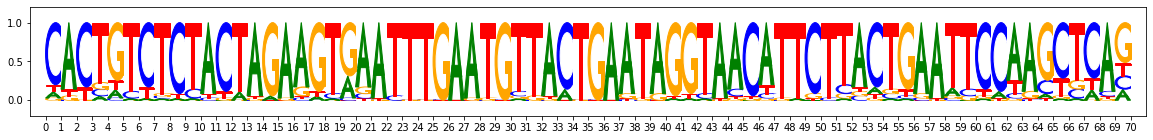

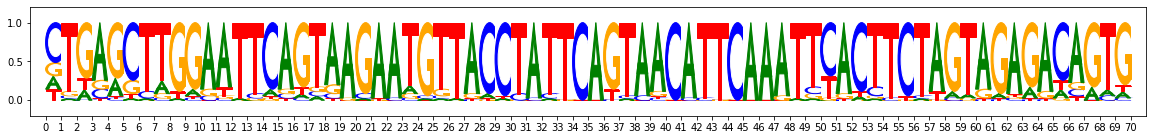

metacluster_0 pattern_20
total seqlets: 64
Task 0 hypothetical scores:


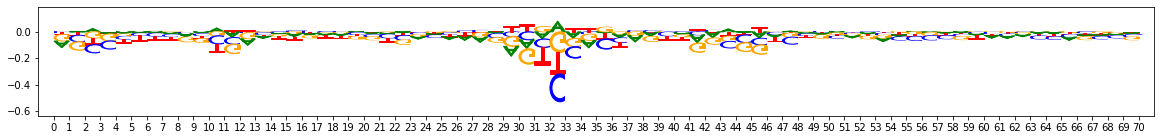

Task 0 actual importance scores:


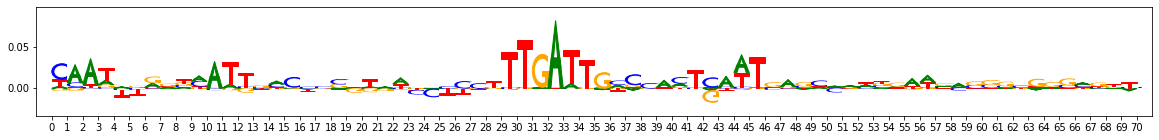

onehot, fwd and rev:


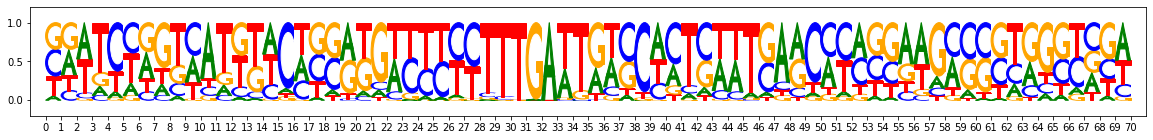

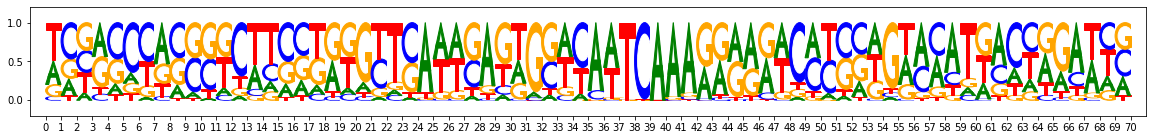

In [13]:
from modisco.visualization import viz_sequence
%matplotlib inline

hdf5_results = h5py.File(file_path,"r")

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []
background = np.array([0.27, 0.23, 0.23, 0.27])

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["Nanog_profile_wn_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["Nanog_profile_wn_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(np.array(pattern["sequence"]["fwd"])) 
        viz_sequence.plot_weights(np.array(pattern["sequence"]["rev"])) 
        
hdf5_results.close()